In [1]:
from roboticstoolbox import DHRobot, RevoluteDH
import numpy as np
import matplotlib.pyplot as plt
from spatialmath import SE3
from tqdm import tqdm

# Define DH parameters
dh = np.array([
    [0, -np.pi/2, 10, 0],
    [50, 0, 0, -np.pi/2],
    [0, -np.pi/2, 5, 0],
    [0, np.pi/2, 50, 0],
    [0, -np.pi/2, 0, 0],
    [0, 0, 10, np.pi]
])

In [2]:
# Create robot model
links = [RevoluteDH(d=row[2], a=row[0], alpha=row[1], offset=row[3]) for row in dh]
robot = DHRobot(links, name="MyRobot")

def test_joint_kinematics(robot, joint_index, initial_angles):
    """
    Test kinematics for a specific joint with given initial angles for other joints.
    
    Args:
    robot (DHRobot): The robot model
    joint_index (int): Index of the joint to vary (0-5)
    initial_angles (list): Initial angles for all joints in degrees
    
    Returns:
    tuple: joint_angles, yaws, pitches, rolls
    """
    joint_angles = np.linspace(-120, 120, 241)
    yaws, pitches, rolls = [], [], []
    
    # Convert initial angles to radians
    q_initial = np.deg2rad(initial_angles)
    
    for angle in joint_angles:
        q = q_initial.copy()
        q[joint_index] = np.deg2rad(angle)
        
        T = robot.fkine(q)
        euler = T.eul()  # Returns [yaw, pitch, roll] in ZYX convention
        yaws.append(np.rad2deg(euler[0]))
        pitches.append(np.rad2deg(euler[1]))
        rolls.append(np.rad2deg(euler[2]))
    
    return joint_angles, yaws, pitches, rolls

def plot_all_joints(robot, initial_angle):
    fig, axs = plt.subplots(2, 3, figsize=(18, 9))
    fig.suptitle(f'Euler Angles vs Joint Angles (Other joints at {initial_angle}°)', fontsize=16)
    
    for i in range(6):
        initial_angles = [initial_angle] * 6
        joint_angles, yaws, pitches, rolls = test_joint_kinematics(robot, i, initial_angles)
        
        row, col = divmod(i, 3)
        ax = axs[row, col]
        ax.plot(joint_angles, yaws, 'b', label='Yaw (Z)')
        ax.plot(joint_angles, pitches, 'r', label='Pitch (Y)')
        ax.plot(joint_angles, rolls, 'g', label='Roll (X)')
        ax.set_xlabel(f'Joint {i+1} Angle (degrees)')
        ax.set_ylabel('Euler Angles (degrees)')
        ax.set_title(f'Joint {i+1}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

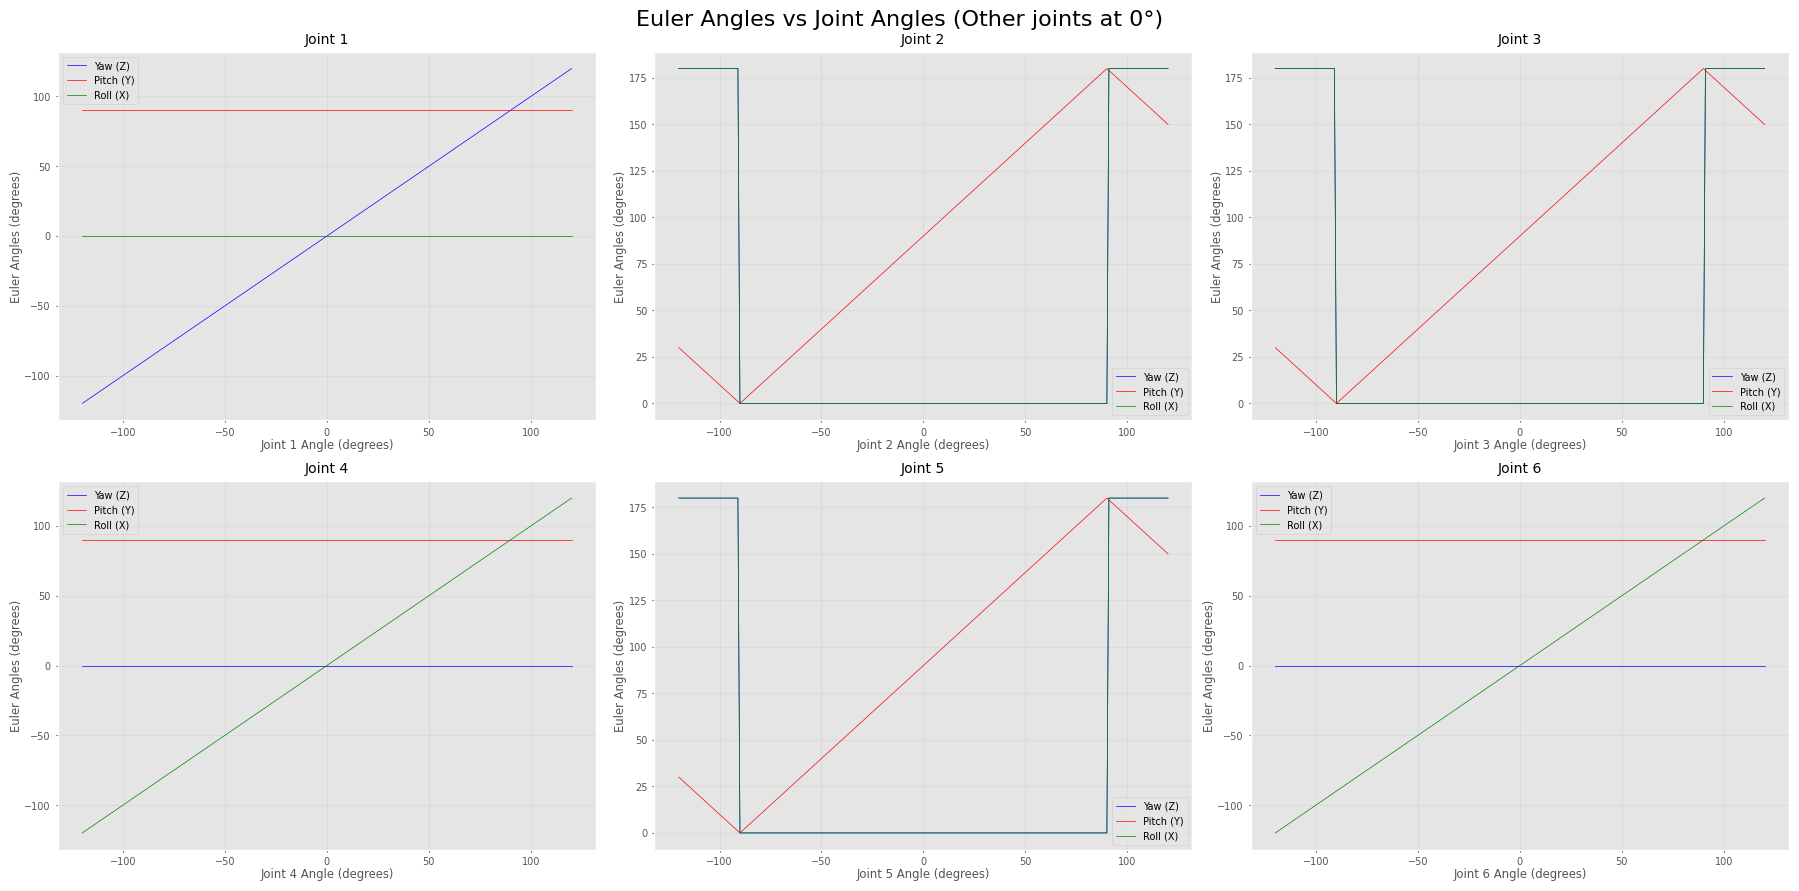

In [3]:
# Generate plots
plot_all_joints(robot, 0)   # All other joints at 0 degrees

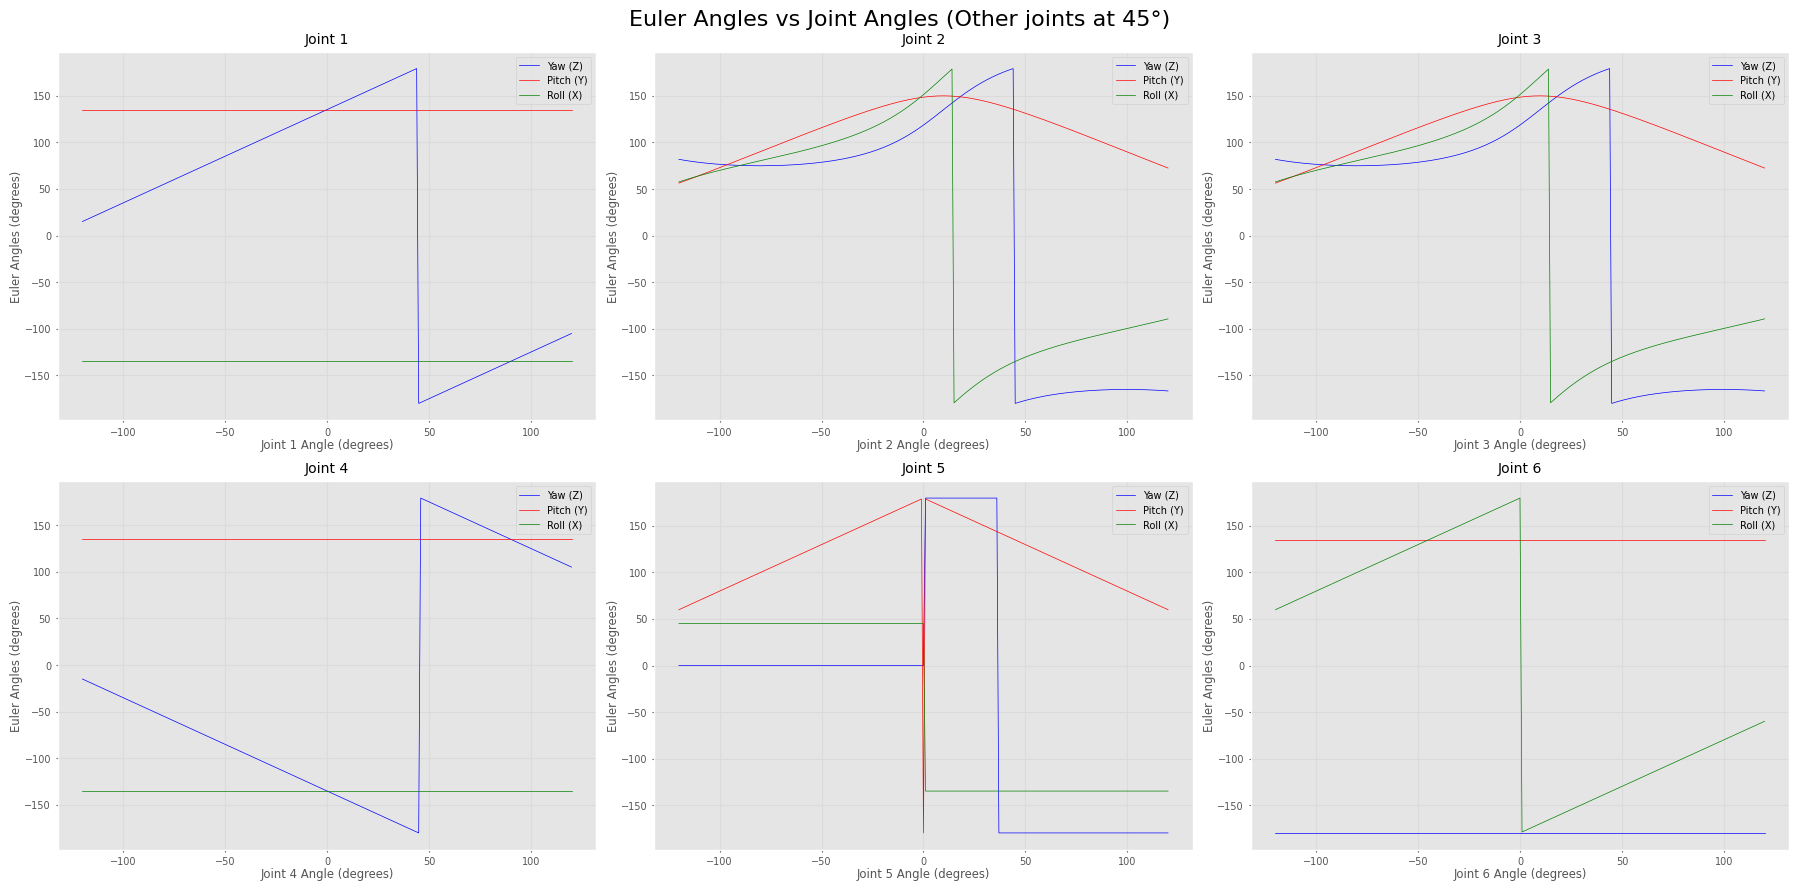

In [4]:
plot_all_joints(robot, 45)  # All other joints at 45 degrees

## Now the custom version

In [5]:
import numpy as np
from spatialmath import SE3
import matplotlib.pyplot as plt

def dh_transform(theta, d, a, alpha):
    """
    Calculate the DH transformation matrix using the provided DH parameters.
    """
    return SE3(np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),                 d],
        [0,              0,                            0,                             1]
    ]))

def forward_kinematics(dh_params, joint_angles):
    """
    Calculate the forward kinematics for a 6-DOF robotic arm using DH parameters and joint angles.
    
    Parameters:
    dh_params (list of list): Each sublist should contain [theta_home, d, a, alpha] for one joint.
    joint_angles (list): List of joint angles [theta1, theta2, ... theta6] in radians.
    
    Returns:
    SE3: Transformation matrix of the end effector.
    """
    # Check if the number of provided joints and angles are both 6
    if len(dh_params) != 6 or len(joint_angles) != 6:
        raise ValueError("The provided DH parameters and joint angles should be for 6 joints each")
    
    # Initialize transformation matrix as identity
    T = SE3()
    
    for i in range(6):
        theta_home, d, a, alpha = dh_params[i]
        theta = theta_home + joint_angles[i]
        T *= dh_transform(theta, d, a, alpha)
        
    return T

def extract_pose(T):
    """
    Extract the position (X, Y, Z) and ZYX Euler angles from the transformation matrix.
    
    Parameters:
    T (SE3): SE3 transformation matrix.
    
    Returns:
    tuple: (X, Y, Z, Euler ZYX angles in radians)
    """
    pos = T.t
    zyx_euler = T.eul('ZYX')
    return pos[0], pos[1], pos[2], zyx_euler

def plot_roll_pitch_yaw(joint_number, angle_range, dh_params, fixed_angles):
    """
    Plot roll, pitch, and yaw against a changing joint angle.
    
    Parameters:
    joint_number (int): The joint number to vary (0-indexed).
    angle_range (tuple): The range of angles to vary the joint (min_angle, max_angle).
    dh_params (list): The DH parameters.
    fixed_angles (list): List of fixed angles for all joints.
    """
    angles = np.linspace(np.radians(angle_range[0]), np.radians(angle_range[1]), num=100)
    roll = []
    pitch = []
    yaw = []
    
    for angle in angles:
        joint_angles = fixed_angles.copy()
        joint_angles[joint_number] = angle
        T = forward_kinematics(dh_params, joint_angles)
        _, _, _, euler_zyx = extract_pose(T)
        roll.append(euler_zyx[2])
        pitch.append(euler_zyx[1])
        yaw.append(euler_zyx[0])
    
    # Convert from radians to degrees for plotting
    roll = np.degrees(roll)
    pitch = np.degrees(pitch)
    yaw = np.degrees(yaw)
    
    plt.figure()
    plt.plot(np.degrees(angles), roll, label='Roll')
    plt.plot(np.degrees(angles), pitch, label='Pitch')
    plt.plot(np.degrees(angles), yaw, label='Yaw')
    plt.xlabel('Joint {} Angle (degrees)'.format(joint_number + 1))
    plt.ylabel('Angle (degrees)')
    plt.legend()
    plt.title('Roll, Pitch, Yaw vs Joint {} Angle'.format(joint_number + 1))
    plt.grid(True)
    plt.show()

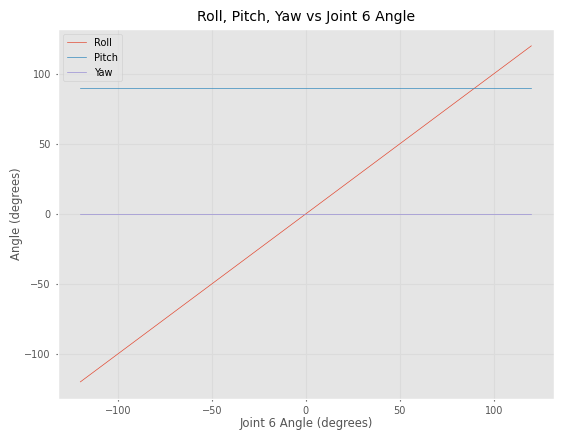

In [6]:
# Provided DH parameters: [theta_home, d, a, alpha]
dh_params = [
    [0, 10, 0, -np.pi/2],
    [-np.pi/2, 0, 50, 0],
    [0, 5, 0, -np.pi/2],
    [0, 50, 0, np.pi/2],
    [0, 0, 0, -np.pi/2],
    [np.pi, 10, 0, 0] # This should be correct as np.pi, considering it as the initial theta position
]

# Example fixed joint angles (in radians) for testing
fixed_angles = [np.radians(0), np.radians(0), np.radians(0), np.radians(0), np.radians(0), np.radians(0)]

# Specify the joint to vary and the range of angles
joint_number_to_vary = 5 # 6th joint (0-indexed)
angle_range = (-120, 120)

# Plot roll, pitch, and yaw for the varying joint
plot_roll_pitch_yaw(joint_number_to_vary, angle_range, dh_params, fixed_angles)

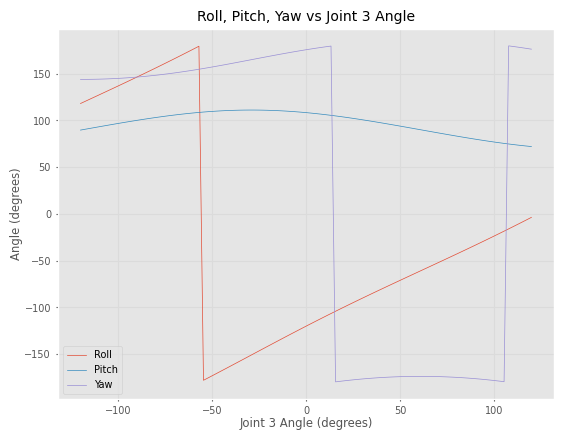

In [7]:
joint_number_to_vary = 2
# Set all joints to -45 degrees (parametrized angles for future)
param_angles = [np.radians(75) for _ in range(6)]

# Plotting for joint angles set to a parametrized value
plot_roll_pitch_yaw(joint_number_to_vary, angle_range, dh_params, param_angles)

# Final test implementation

In [8]:
import numpy as np
from spatialmath import SE3
import matplotlib.pyplot as plt

def dh_transform(theta, d, a, alpha):
    """
    Calculate the DH transformation matrix using the provided DH parameters.
    """
    return SE3(np.array([
        [np.cos(theta), -np.sin(theta) * np.cos(alpha),  np.sin(theta) * np.sin(alpha), a * np.cos(theta)],
        [np.sin(theta),  np.cos(theta) * np.cos(alpha), -np.cos(theta) * np.sin(alpha), a * np.sin(theta)],
        [0,              np.sin(alpha),                np.cos(alpha),                 d],
        [0,              0,                            0,                             1]
    ]))

def forward_kinematics(dh_params, joint_angles):
    """
    Calculate the forward kinematics for a 6-DOF robotic arm using DH parameters and joint angles.
    
    Parameters:
    dh_params (list of list): Each sublist should contain [theta_home, d, a, alpha] for one joint.
    joint_angles (list): List of joint angles [theta1, theta2, ... theta6] in radians.
    
    Returns:
    SE3: Transformation matrix of the end effector.
    """
    # Check if the number of provided joints and angles are both 6
    if len(dh_params) != 6 or len(joint_angles) != 6:
        raise ValueError("The provided DH parameters and joint angles should be for 6 joints each")
    
    # Initialize transformation matrix as identity
    T = SE3()
    
    for i in range(6):
        theta_home, d, a, alpha = dh_params[i]
        theta = theta_home + joint_angles[i]
        T *= dh_transform(theta, d, a, alpha)
        
    return T

def extract_pose(T):
    """
    Extract the position (X, Y, Z) and ZYX Euler angles from the transformation matrix.
    
    Parameters:
    T (SE3): SE3 transformation matrix.
    
    Returns:
    tuple: (X, Y, Z, Euler ZYX angles in radians)
    """
    pos = T.t
    zyx_euler = T.eul('ZYX')
    return pos[0], pos[1], pos[2], zyx_euler

def test_joint_kinematics(joint_index, initial_angles):
    """
    Test kinematics for a specific joint with given initial angles for other joints.
    
    Args:
    joint_index (int): Index of the joint to vary (0-5)
    initial_angles (list): Initial angles for all joints in degrees
    
    Returns:
    tuple: joint_angles, yaws, pitches, rolls
    """
    joint_angles = np.linspace(-120, 120, 241)
    yaws, pitches, rolls = [], [], []
    initial_angles_rad = np.radians(initial_angles)
    
    for angle in joint_angles:
        test_angles = initial_angles_rad.copy()
        test_angles[joint_index] = np.radians(angle)
        
        T = forward_kinematics(dh_params, test_angles)
        _, _, _, euler_zyx = extract_pose(T)
        
        yaws.append(np.degrees(euler_zyx[0]))
        pitches.append(np.degrees(euler_zyx[1]))
        rolls.append(np.degrees(euler_zyx[2]))
    
    return joint_angles, yaws, pitches, rolls

def plot_all_joints(initial_angle):
    fig, axs = plt.subplots(2, 3, figsize=(18, 9))
    fig.suptitle(f'Euler Angles vs Joint Angles (Other joints at {initial_angle}°)', fontsize=16)
    
    for i in range(6):
        initial_angles = [initial_angle] * 6
        joint_angles, yaws, pitches, rolls = test_joint_kinematics(i, initial_angles)
        
        row, col = divmod(i, 3)
        ax = axs[row, col]
        ax.plot(joint_angles, yaws, 'b', label='Yaw (Z)')
        ax.plot(joint_angles, pitches, 'r', label='Pitch (Y)')
        ax.plot(joint_angles, rolls, 'g', label='Roll (X)')
        ax.set_xlabel(f'Joint {i+1} Angle (degrees)')
        ax.set_ylabel('Euler Angles (degrees)')
        ax.set_title(f'Joint {i+1}')
        ax.legend()
        ax.grid(True)
    
    plt.tight_layout()
    plt.show()

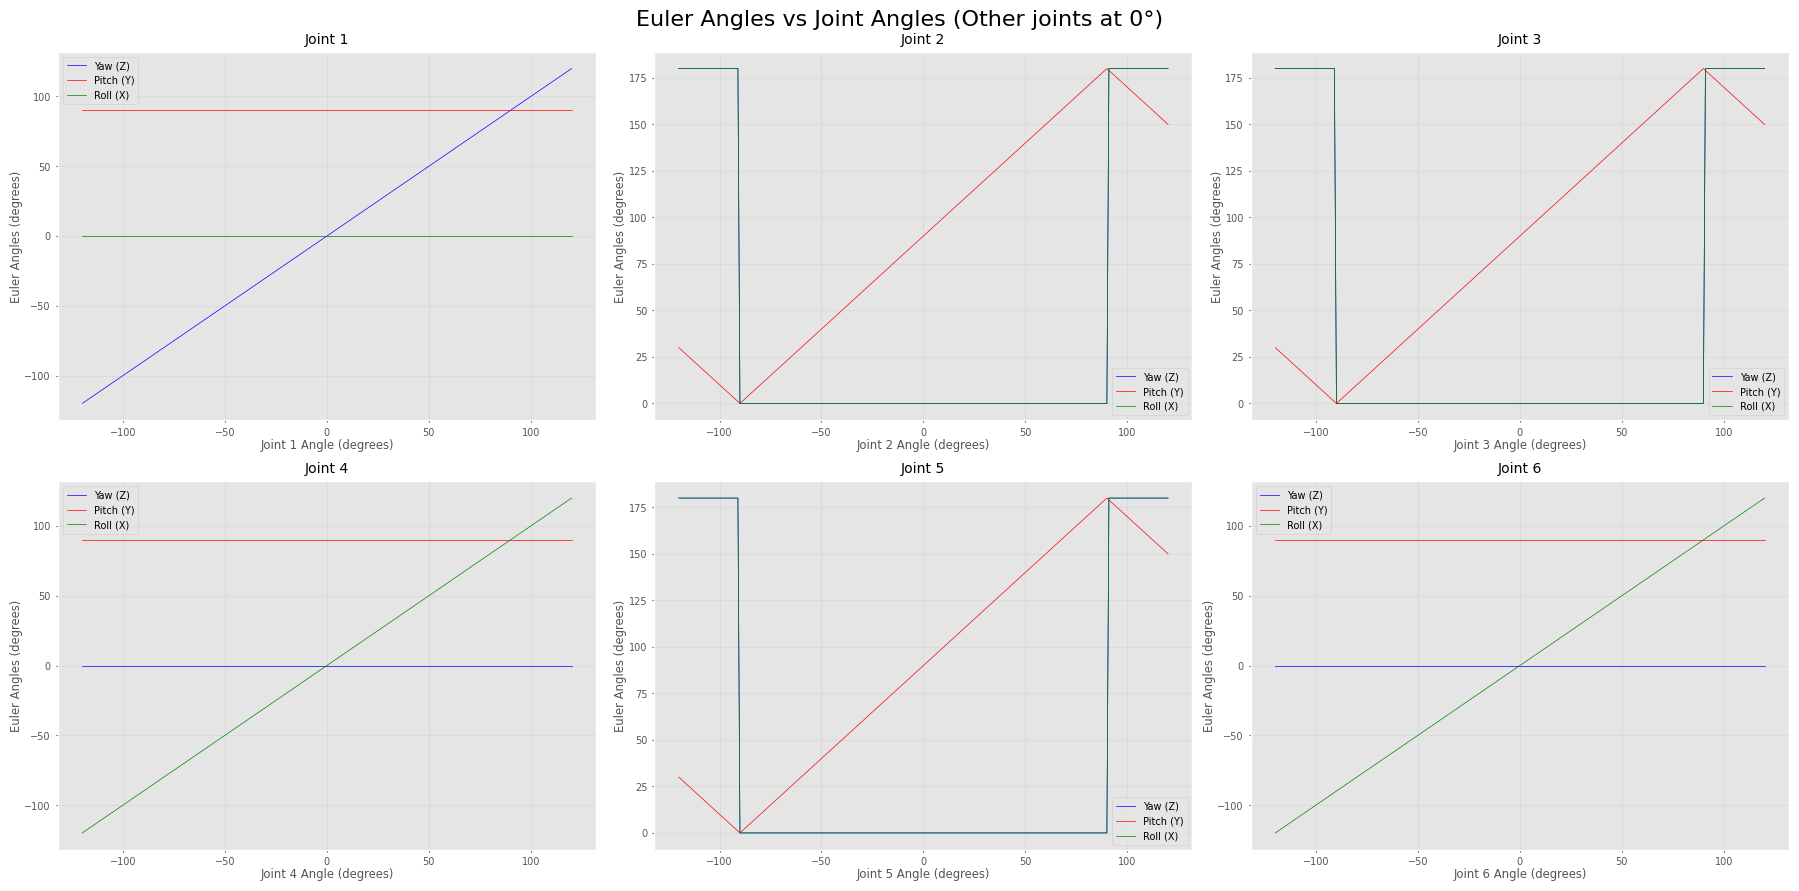

In [9]:
# Provided DH parameters: [theta_home, d, a, alpha]
dh_params = [
    [0, 10, 0, -np.pi/2],
    [-np.pi/2, 0, 50, 0],
    [0, 5, 0, -np.pi/2],
    [0, 50, 0, np.pi/2],
    [0, 0, 0, -np.pi/2],
    [np.pi, 10, 0, 0] # This should be np.pi, considering it as the initial theta position
]

# Test the function with all joints set to 0° initially
test_joint_kinematics(5, [0, 0, 0, 0, 0, 0])

# Plot for all joints with initial angle set to -45°
plot_all_joints(0)

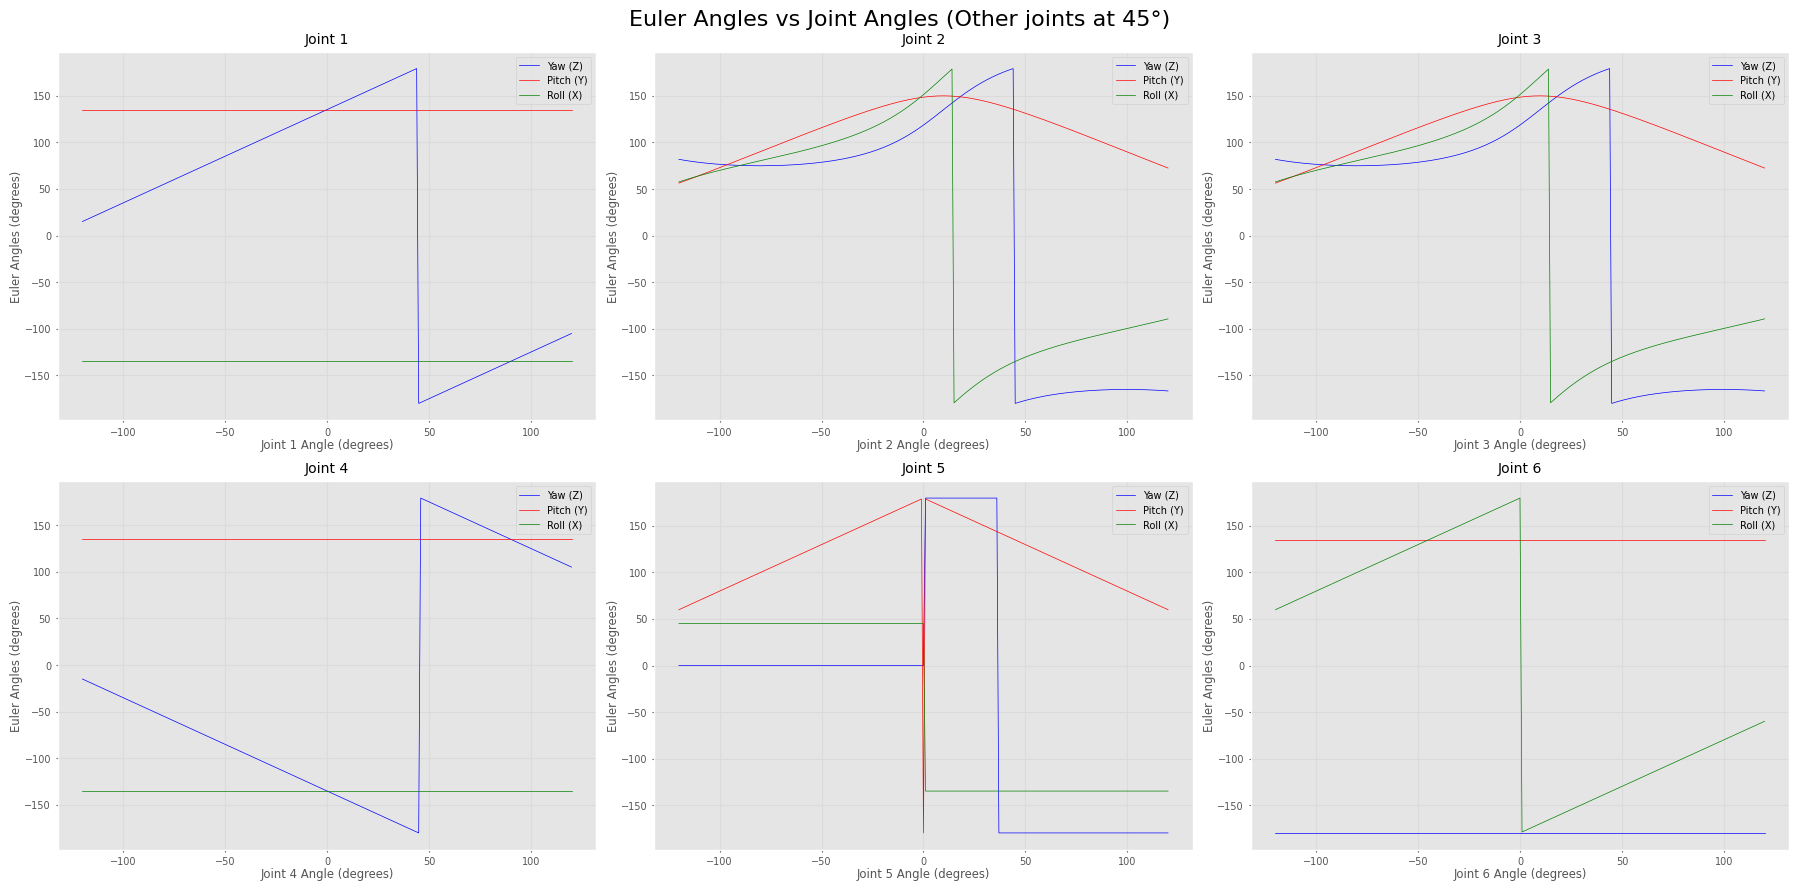

In [10]:
# Plot for all joints with initial angle set to 45°
plot_all_joints(45)